In [1]:
from mxnet import gluon

root_url = ('https://apache-mxnet.s3-accelerate.amazonaws.com/'
            'gluon/dataset/pikachu/')
data_dir = '../data/pikachu/'
dataset = {'train.rec': 'e6bcb6ffba1ac04ff8a9b1115e650af56ee969c8',
          'train.idx': 'dcf7318b2602c06428b9988470c731621716c393',
          'val.rec': 'd6c33f799b4d058e82f2cb5bd9a976f69d72d520'}
for k, v in dataset.items():
    gluon.utils.download(root_url+k, data_dir+k, sha1_hash=v)

In [7]:
from mxnet import image
from mxnet import nd

data_shape = 256
batch_size = 32
rgb_mean = nd.array([123, 117, 104])

def get_iterators(data_shape, batch_size):
    class_names = ['pikachu']
    num_class = len(class_names)
    train_iter = image.ImageDetIter(
        batch_size = batch_size,
        data_shape = (3, data_shape, data_shape),
        path_imgrec = 'data/pikachu/train.rec',
        path_imgidx = 'data/pikachu/train.idx',
        shuffle = True,
        mean = True,
        rand_crop = 1,
        min_object_covered = 0.95,
        max_attempts = 200
    )
    val_iter = image.ImageDetIter(
        batch_size = batch_size,
        data_shape = (3, data_shape, data_shape),
        path_imgrec = 'data/pikachu/val.rec',
        shuffle = False,
        mean = True
    )
    return train_iter, val_iter, class_names, num_class

train_data, test_data, class_names, num_class = get_iterators(
    data_shape, batch_size)

In [8]:
batch = train_data.next()
print(batch)

DataBatch: data shapes: [(32, 3, 256, 256)] label shapes: [(32, 1, 5)]


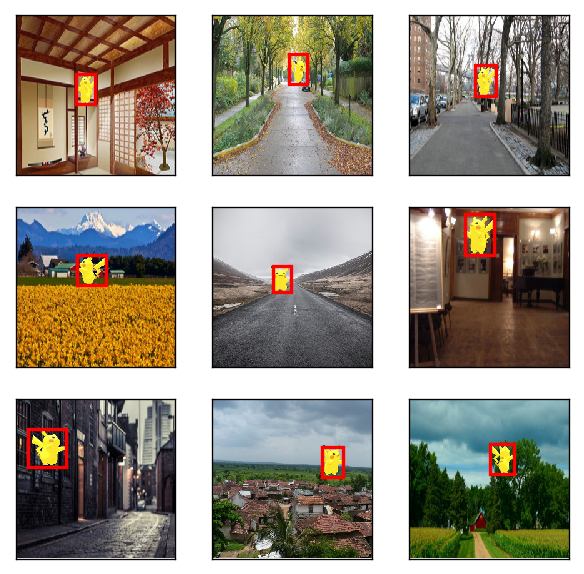

In [12]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 120
import matplotlib.pyplot as plt

def box_to_rect(box, color, linewidth=3):
    """convert an anchor box to a matplotlib rectangle"""
    box = box.asnumpy()
    return plt.Rectangle(
        (box[0], box[1]), box[2]-box[0], box[3]-box[1],
        fill=False, edgecolor=color, linewidth=linewidth)

_, figs = plt.subplots(3, 3, figsize=(6,6))
for i in range(3):
    for j in range(3):
        img, labels = batch.data[0][3*i+j], batch.label[0][3*i+j]
        # (3L, 256L, 256L) => (256L, 256L, 3L)
        img = img.transpose((1, 2, 0)) + rgb_mean
        img = img.clip(0,255).asnumpy()/255
        fig = figs[i][j]
        fig.imshow(img)
        for label in labels:
            rect = box_to_rect(label[1:5]*data_shape,'red',2)
            fig.add_patch(rect)
        fig.axes.get_xaxis().set_visible(False)
        fig.axes.get_yaxis().set_visible(False)
plt.show()

In [14]:
from mxnet import nd
from mxnet.contrib.ndarray import MultiBoxPrior

n = 40
x = nd.random.uniform(shape = (1, 3, n, n))

y = MultiBoxPrior(x, sizes = [.5, .25, .1], ratios = [1, 2, .5])

boxes = y.reshape((n, n, -1, 4))
print(boxes.shape)

boxes[20, 20, 0, :]

(40, 40, 5, 4)



[ 0.26249999  0.26249999  0.76249999  0.76249999]
<NDArray 4 @cpu(0)>

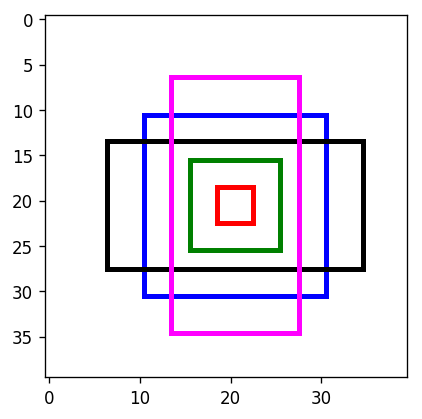

In [15]:
colors = ['blue', 'green', 'red', 'black', 'magenta']

plt.imshow(nd.ones((n, n, 3)).asnumpy())
anchors = boxes[20, 20, :, :]
for i in range(anchors.shape[0]):
    plt.gca().add_patch(box_to_rect(anchors[i,:] * n, colors[i]))
plt.show()

In [16]:
from mxnet.gluon import nn
def class_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), 3, padding = 1)

cls_pred = class_predictor(5, 10)
cls_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = cls_pred(x)
y.shape

(2, 55, 20, 20)

In [17]:
def box_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, 3, padding = 1)

box_pred = box_predictor(10)
box_pred.initialize()
x = nd.zeros((2, 3, 20, 20))
y = box_pred(x)
y.shape

(2, 40, 20, 20)

In [18]:
def down_sample(num_filters):
    out = nn.HybridSequential()
    for _ in range(2):
        out.add(nn.Conv2D(num_filters, 3, strides = 1, padding = 1))
        out.add(nn.BatchNorm(in_channels = num_filters))
        out.add(nn.Activation('relu'))
    out.add(nn.MaxPool2D(2))
    return out

blk = down_sample(10)
blk.initialize()
x = nd.zeros((2, 3, 20, 20))
y = blk(x)
y.shape

(2, 10, 10, 10)

In [19]:
x = nd.zeros((2, 8, 20, 20))
print('x:', x.shape)

cls_pred1 = class_predictor(5, 10)
cls_pred1.initialize()
y1 = cls_pred1(x)
print('Class prediction 1:', y1.shape)

ds = down_sample(16)
ds.initialize()
x = ds(x)
print('x:', x.shape)

cls_pred2 = class_predictor(3, 10)
cls_pred2.initialize()
y2 = cls_pred2(x)
print('Class prediction 2:', y2.shape)

x: (2, 8, 20, 20)
Class prediction 1: (2, 55, 20, 20)
x: (2, 16, 10, 10)
Class prediction 2: (2, 33, 10, 10)


In [20]:
def flatten_prediction(pred):
    return pred.transpose(axes=(0,2,3,1)).flatten()

def concat_predictions(preds):
    return nd.concat(*preds, dim=1)

flat_y1 = flatten_prediction(y1)
print('Flatten class prediction 1', flat_y1.shape)
flat_y2 = flatten_prediction(y2)
print('Flatten class prediction 2', flat_y2.shape)
y = concat_predictions([flat_y1, flat_y2])
print('Concat class predictions', y.shape)

Flatten class prediction 1 (2, 22000)
Flatten class prediction 2 (2, 3300)
Concat class predictions (2, 25300)


In [23]:
def body():
    out = nn.HybridSequential()
    for nfilters in [16, 32, 64]:
        out.add(down_sample(nfilters))
    return out

bnet = body()
bnet.initialize()
x = nd.random.uniform(shape = (2, 3, 256, 256))
y = bnet(x)
y.shape

(2, 64, 32, 32)

In [28]:

def toy_ssd_model(num_anchors, num_classes):
    downsamplers = nn.Sequential()
    for _ in range(3):
        downsamplers.add(down_sample(128))

    class_predictors = nn.Sequential()
    box_predictors = nn.Sequential()
    for _ in range(5):
        class_predictors.add(class_predictor(num_anchors, num_classes))
        box_predictors.add(box_predictor(num_anchors))

    model = nn.Sequential()
    model.add(body(), downsamplers, class_predictors, box_predictors)
    return model

In [29]:
def toy_ssd_forward(x, model, sizes, ratios, verbose=False):
    body, downsamplers, class_predictors, box_predictors = model
    anchors, class_preds, box_preds = [], [], []
    # feature extraction
    x = body(x)
    for i in range(5):
        # predict
        anchors.append(MultiBoxPrior(
            x, sizes=sizes[i], ratios=ratios[i]))
        class_preds.append(
            flatten_prediction(class_predictors[i](x)))
        box_preds.append(
            flatten_prediction(box_predictors[i](x)))
        if verbose:
            print('Predict scale', i, x.shape, 'with',
                  anchors[-1].shape[1], 'anchors')
        # down sample
        if i < 3:
            x = downsamplers[i](x)
        elif i == 3:
            x = nd.Pooling(
                x, global_pool=True, pool_type='max',
                kernel=(x.shape[2], x.shape[3]))
    # concat date
    return (concat_predictions(anchors),
            concat_predictions(class_preds),
            concat_predictions(box_preds))

In [30]:

from mxnet import gluon
class ToySSD(gluon.Block):
    def __init__(self, num_classes, verbose=False, **kwargs):
        super(ToySSD, self).__init__(**kwargs)
        # anchor box sizes and ratios for 5 feature scales
        self.sizes = [[.2,.272], [.37,.447], [.54,.619],
                      [.71,.79], [.88,.961]]
        self.ratios = [[1,2,.5]]*5
        self.num_classes = num_classes
        self.verbose = verbose
        num_anchors = len(self.sizes[0]) + len(self.ratios[0]) - 1
        # use name_scope to guard the names
        with self.name_scope():
            self.model = toy_ssd_model(num_anchors, num_classes)

    def forward(self, x):
        anchors, class_preds, box_preds = toy_ssd_forward(
            x, self.model, self.sizes, self.ratios,
            verbose=self.verbose)
        # it is better to have class predictions reshaped for softmax computation
        class_preds = class_preds.reshape(shape=(0, -1, self.num_classes+1))
        return anchors, class_preds, box_preds

In [31]:

net = ToySSD(num_classes=2, verbose=True)
net.initialize()
x = batch.data[0][0:1]
print('Input:', x.shape)
anchors, class_preds, box_preds = net(x)
print('Output achors:', anchors.shape)
print('Output class predictions:', class_preds.shape)
print('Output box predictions:', box_preds.shape)

Input: (1, 3, 256, 256)
Predict scale 0 (1, 64, 32, 32) with 4096 anchors
Predict scale 1 (1, 128, 16, 16) with 1024 anchors
Predict scale 2 (1, 128, 8, 8) with 256 anchors
Predict scale 3 (1, 128, 4, 4) with 64 anchors
Predict scale 4 (1, 128, 1, 1) with 4 anchors
Output achors: (1, 5444, 4)
Output class predictions: (1, 5444, 3)
Output box predictions: (1, 21776)


In [32]:
from mxnet.contrib.ndarray import MultiBoxTarget
def training_targets(anchors, class_preds, labels):
    class_preds = class_preds.transpose(axes=(0,2,1))
    return MultiBoxTarget(anchors, labels, class_preds)

out = training_targets(anchors, class_preds, batch.label[0][0:1])
out

[
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x21776 @cpu(0)>, 
 [[ 0.  0.  0. ...,  0.  0.  0.]]
 <NDArray 1x5444 @cpu(0)>]

In [33]:
out[1].sum()/4


[ 10.]
<NDArray 1 @cpu(0)>

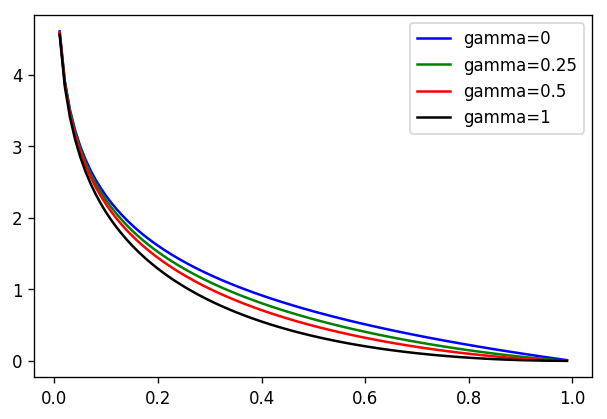

In [34]:

import numpy as np

def focal_loss(gamma, x):
    return - (1-x)**gamma*np.log(x)

x = np.arange(0.01, 1, .01)
gammas = [0,.25,.5,1]
for i,g in enumerate(gammas):
    plt.plot(x, focal_loss(g,x), colors[i])

plt.legend(['gamma='+str(g) for g in gammas])
plt.show()

In [35]:

class FocalLoss(gluon.loss.Loss):
    def __init__(self, axis=-1, alpha=0.25, gamma=2, batch_axis=0, **kwargs):
        super(FocalLoss, self).__init__(None, batch_axis, **kwargs)
        self._axis = axis
        self._alpha = alpha
        self._gamma = gamma

    def hybrid_forward(self, F, output, label):
        output = F.softmax(output)
        pj = output.pick(label, axis=self._axis, keepdims=True)
        loss = - self._alpha * ((1 - pj) ** self._gamma) * pj.log()
        return loss.mean(axis=self._batch_axis, exclude=True)

cls_loss = FocalLoss()
cls_loss

FocalLoss(batch_axis=0, w=None)

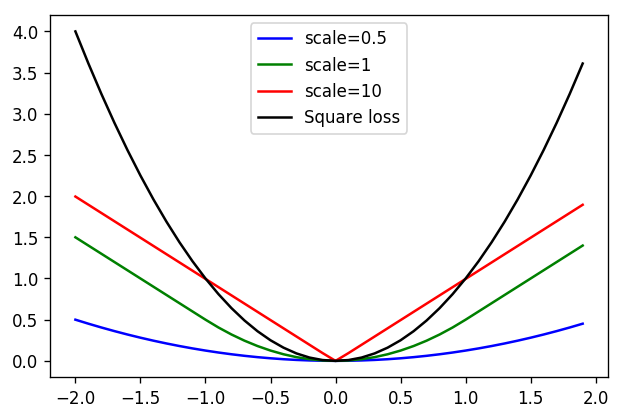

In [36]:
scales = [.5, 1, 10]
x = nd.arange(-2, 2, 0.1)

for i,s in enumerate(scales):
    y = nd.smooth_l1(x, scalar=s)
    plt.plot(x.asnumpy(), y.asnumpy(), color=colors[i])
plt.plot(x.asnumpy(), (x**2).asnumpy(), color=colors[len(scales)])
plt.legend(['scale='+str(s) for s in scales]+['Square loss'])
plt.show()

In [37]:
class SmoothL1Loss(gluon.loss.Loss):
    def __init__(self, batch_axis=0, **kwargs):
        super(SmoothL1Loss, self).__init__(None, batch_axis, **kwargs)

    def hybrid_forward(self, F, output, label, mask):
        loss = F.smooth_l1((output - label) * mask, scalar=1.0)
        return loss.mean(self._batch_axis, exclude=True)

box_loss = SmoothL1Loss()
box_loss

SmoothL1Loss(batch_axis=0, w=None)

In [38]:
from mxnet import metric

cls_metric = metric.Accuracy()
box_metric = metric.MAE()

In [39]:
from mxnet import init
from mxnet import gpu

ctx = gpu(0)
# the CUDA implementation requres each image has at least 3 lables.
# Padd two -1 labels for each instance
train_data.reshape(label_shape=(3, 5))
train_data = test_data.sync_label_shape(train_data)

net = ToySSD(num_class)
net.initialize(init.Xavier(magnitude=2), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(),
                        'sgd', {'learning_rate': 0.1, 'wd': 5e-4})

In [40]:
import time
from mxnet import autograd
for epoch in range(30):
    # reset data iterators and metrics
    train_data.reset()
    cls_metric.reset()
    box_metric.reset()
    tic = time.time()
    for i, batch in enumerate(train_data):
        x = batch.data[0].as_in_context(ctx)
        y = batch.label[0].as_in_context(ctx)
        with autograd.record():
            anchors, class_preds, box_preds = net(x)
            box_target, box_mask, cls_target = training_targets(
                anchors, class_preds, y)
            # losses
            loss1 = cls_loss(class_preds, cls_target)
            loss2 = box_loss(box_preds, box_target, box_mask)
            loss = loss1 + loss2
        loss.backward()
        trainer.step(batch_size)
        # update metrics
        cls_metric.update([cls_target], [class_preds.transpose((0,2,1))])
        box_metric.update([box_target], [box_preds * box_mask])

    print('Epoch %2d, train %s %.2f, %s %.5f, time %.1f sec' % (
        epoch, *cls_metric.get(), *box_metric.get(), time.time()-tic
    ))

Epoch  0, train accuracy 0.96, mae 0.00512, time 9.5 sec
Epoch  1, train accuracy 0.99, mae 0.00366, time 7.8 sec
Epoch  2, train accuracy 0.99, mae 0.00363, time 7.8 sec
Epoch  3, train accuracy 0.99, mae 0.00323, time 7.8 sec
Epoch  4, train accuracy 0.99, mae 0.00322, time 7.9 sec
Epoch  5, train accuracy 0.99, mae 0.00323, time 7.8 sec
Epoch  6, train accuracy 1.00, mae 0.00300, time 7.9 sec
Epoch  7, train accuracy 1.00, mae 0.00293, time 8.0 sec
Epoch  8, train accuracy 1.00, mae 0.00287, time 7.9 sec
Epoch  9, train accuracy 1.00, mae 0.00272, time 8.1 sec
Epoch 10, train accuracy 1.00, mae 0.00270, time 7.9 sec
Epoch 11, train accuracy 1.00, mae 0.00272, time 7.7 sec
Epoch 12, train accuracy 1.00, mae 0.00262, time 8.0 sec
Epoch 13, train accuracy 1.00, mae 0.00285, time 7.9 sec
Epoch 14, train accuracy 1.00, mae 0.00279, time 7.8 sec
Epoch 15, train accuracy 1.00, mae 0.00269, time 7.6 sec
Epoch 16, train accuracy 1.00, mae 0.00265, time 7.8 sec
Epoch 17, train accuracy 1.00, 

In [41]:
def process_image(fname):
    with open(fname, 'rb') as f:
        im = image.imdecode(f.read())
    # resize to data_shape
    data = image.imresize(im, data_shape, data_shape)
    # minus rgb mean
    data = data.astype('float32') - rgb_mean
    # convert to batch x channel x height xwidth
    return data.transpose((2,0,1)).expand_dims(axis=0), im

In [42]:
from mxnet.contrib.ndarray import MultiBoxDetection

def predict(x):
    anchors, cls_preds, box_preds = net(x.as_in_context(ctx))
    cls_probs = nd.SoftmaxActivation(
        cls_preds.transpose((0,2,1)), mode='channel')

    return MultiBoxDetection(cls_probs, box_preds, anchors,
                             force_suppress=True, clip=False)

In [ ]:
x, im = process_image('../img/pikachu.jpg')
out = predict(x)
out.shape

In [ ]:

mpl.rcParams['figure.figsize'] = (6,6)

def display(im, out, threshold=0.5):
    plt.imshow(im.asnumpy())
    for row in out:
        row = row.asnumpy()
        class_id, score = int(row[0]), row[1]
        if class_id < 0 or score < threshold:
            continue
        color = colors[class_id%len(colors)]
        box = row[2:6] * np.array([im.shape[0],im.shape[1]]*2)
        rect = box_to_rect(nd.array(box), color, 2)
        plt.gca().add_patch(rect)

        text = class_names[class_id]
        plt.gca().text(box[0], box[1],
                       '{:s} {:.2f}'.format(text, score),
                       bbox=dict(facecolor=color, alpha=0.5),
                       fontsize=10, color='white')
    plt.show()

display(im, out[0], threshold=0.5)